In [46]:
#libraries used

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from scipy import stats
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
import os
from statistics import mean
import eppy as eppy
from eppy import modeleditor
from eppy.modeleditor import IDF
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
from eppy.runner.run_functions import runIDFs
from eppy.results import readhtml
import random
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors



In [47]:
os.chdir('C:\\Users\\amitc_crl\\OneDrive\\Documents\\GitHub\\IIT-PhD\\CAE526\\P1')

df = pd.read_csv('CAE526-P1_HH UtilityData_Mitchell.csv')
dfm = pd.read_csv('HH_FinalMeter.csv')
dfmi = pd.read_csv('HH_init.csv')
gsf = 111135

df2012 = df.iloc[7:19]
df2013 = df.iloc[19:31]
df2020 = df.iloc[37:49]
eui2012 = (df2012.sum(axis=0)[1] + df2012.sum(axis=0)[3] + df2012.sum(axis=0)[5])/gsf
eui2013 = (df2013.sum(axis=0)[1] + df2013.sum(axis=0)[3] + df2013.sum(axis=0)[5])/gsf
eui2020 = (df2020.sum(axis=0)[1] + df2020.sum(axis=0)[3] + df2020.sum(axis=0)[5])/gsf

print('EUI 2012 = ' + str(eui2012))
# print('EUI 2013 = ' + str(eui2013))
# print('EUI 2020 = ' + str(eui2020))

df2012 = df2012.reset_index()

df2012.head()

df

EUI 2012 = 102.36085121698834


,MONTH,STEAM [kBTU],ELEC [kWh],ELEC [kBTU],CHW [Ton-hr],CHW [kBTU],DHW [gal],AVG TEMP [F]
0,Jun-11,94080.0,81793.0,279159.5,7300.0,87600.0,998200.0,70.7
1,Jul-11,33360.0,90032.0,307279.2,10808.3,129700.0,1113700.0,79.9
2,Aug-11,17090.0,87106.0,297292.8,1550.0,18600.0,832700.0,74.3
3,Sep-11,165250.0,87828.0,299757.0,683.3,8200.0,702100.0,63.3
4,Oct-11,740440.0,89589.0,305767.3,441.7,5300.0,264200.0,55.6
...,...,...,...,...,...,...,...,...
2317,NaN,NaN,NaN,19.0,NaN,NaN,NaN,NaN
2318,NaN,NaN,NaN,20.0,NaN,NaN,NaN,NaN
2319,NaN,NaN,NaN,20.0,NaN,NaN,NaN,NaN
2320,NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN


In [48]:
def cvrsme(meterData, simData):
    data = []
    n = len(meterData)
    y_bar = mean(meterData)
    for m,s in zip(meterData,simData):
        data.append((((m-s)**2)/(n-1)))
    CVRSME = 100*(1/y_bar)*(sum(data)**(1/2))
    return CVRSME

def nmbe(meterData, simData):
    data = []
    n = len(meterData)
    y_bar = mean(meterData)
    for m,s in zip(meterData,simData):
        data.append(m-s)
    NMBE = (((sum(data))/((n-1)*y_bar))*100)
    return NMBE

In [49]:
simData = pd.read_csv('data.csv')

elecSim = simData['Electricity [kWh]']
elecMet = df2012['ELEC [kWh]']

print('Electricity CVRSME:')
print(cvrsme(elecMet, elecSim))

chwSim = simData['Cooling [kBtu]']
chwMet = df2012['CHW [kBTU]']

print('Chilled Water CVRSME:')
print(cvrsme(chwMet, chwSim))

heatSim = simData['Heating [kbtu]']
heatMet = df2012['STEAM [kBTU]']

print('District Heating CVRSME:')
print(cvrsme(heatMet, heatSim))

Electricity CVRSME:
25.171269287918843
Chilled Water CVRSME:
3201.5733062739764
District Heating CVRSME:
42.51478167230881


In [50]:
print('Electricity NMBE:')
print(nmbe(elecMet, elecSim))

print('Chilled Water NMBE:')
print(nmbe(chwMet, chwSim))

print('District Heating NMBE:')
print(nmbe(heatMet, heatSim))

Electricity NMBE:
22.48977043173896
Chilled Water NMBE:
-2179.6510414792965
District Heating NMBE:
8.519809763516434


In [51]:
# os.chdir('C:\\Users\\amitc_crl\\OneDrive\\Documents\\GitHub\\IIT-PhD\\CAE526\\P1')
# IDF.setiddname("C:\EnergyPlusV22-1-0\Energy+.idd")
# epwfile = "USA_IL_Chicago.Midway.Intl.AP.725340_TMY3.epw"
# idf1 = IDF('in.idf')
# idf2 = IDF('in.idf')
# #Multivariate

# # results = pd.DataFrame(columns=list('ABCDEFGHIKL'))
# # results.to_csv('results.csv')
# global final
# final = []

# idf1.saveas('eplusTEMP.idf')
# idf2.saveas('in.idf')

# def f2(params):
#     global final
#     u,shgc,leakage,lpd,people = params
#     # results = pd.read_csv('results.csv')

#     idf1 = IDF('in.idf')
#     # idf1.saveas('eplusTEMP.idf')
    
#     # window = idf1.idfobjects['Window'][2]
#     # window.Height = x[0]
#     # window = idf1.idfobjects['Window'][3]
#     # window.Height = x[1]

#     count = -1
#     for i in idf1.idfobjects['WindowMaterial:SimpleGlazingSystem']:
#         count += 1
#         glz = idf1.idfobjects['WindowMaterial:SimpleGlazingSystem'][count]
#         if glz.Name == 'Parametric Glass':
#             glz.UFactor = (glz.UFactor * u)
#             glz.Solar_Heat_Gain_Coefficient = (glz.Solar_Heat_Gain_Coefficient * shgc)

#     count = -1
#     for i in idf1.idfobjects['ZoneInfiltration:DesignFlowRate']:
#         count += 1
#         inf = idf1.idfobjects['ZoneInfiltration:DesignFlowRate'][count]
#         inf.Flow_per_Exterior_Surface_Area = (inf.Flow_per_Exterior_Surface_Area * leakage)

#     count = -1
#     for i in idf1.idfobjects['Lights']:
#         count += 1
#         light = idf1.idfobjects['Lights'][count]
#         light.Watts_per_Zone_Floor_Area = (light.Watts_per_Zone_Floor_Area * lpd)

#     count = -1
#     for i in idf1.idfobjects['People']:
#         count += 1
#         ppl = idf1.idfobjects['People'][count]
#         ppl.People_per_Floor_Area = (ppl.People_per_Floor_Area * people)

#     idf1.saveas('eplusTEMP.idf')

#     idf = IDF('eplusTEMP.idf', epwfile)
#     idf.run(readvars = True)

#     data = pd.read_csv('eplusmtr.csv')
#     elecSim = list(data['Electricity:Facility [J](Monthly)'].mul(2.7777e-7))
#     chwSim = list(data['DistrictCooling:Facility [J](Monthly)'].mul(9e-7))
#     heatSim = list(data['DistrictHeating:Facility [J](Monthly) '].mul(9e-7))
#     elecCVRSME = cvrsme(elecMet, elecSim)
#     chwCVRSME  = cvrsme(chwMet, chwSim)
#     heatCVRSME = cvrsme(heatMet, heatSim)

#     elecNMBE = nmbe(elecMet, elecSim)
#     chwNMBE = nmbe(chwMet, chwSim)
#     heatNMBE = nmbe(heatMet, heatSim)
#     print(elecCVRSME)
#     print(chwCVRSME)
#     print(heatCVRSME)

#     newRow = [u,shgc,leakage,lpd,people,elecCVRSME,chwCVRSME,heatCVRSME,elecNMBE,chwNMBE,heatNMBE]
#     final.append(newRow)
#     print(final)
#     # newRow = pd.DataFrame([[u,shgc,leakage,lpd,people,elecCVRSME,chwCVRSME,heatCVRSME,elecCVRSME,chwCVRSME,heatCVRSME]], columns=list('ABCDEFGHIKL'))
#     # results = results.concat(newRow, ignore_index=True)
#             #    columns=['u','shgc','leakage','lpd','people','elecCVRSME','chwCVRSME','heatCVRSME','elecCVRSME','chwCVRSME','heatCVRSME']),
#             #    ignore_index = True)
#     # results = pd.concat(results, newRow)
#     # filehandle = open(fname, 'r').read()
#     # htables = readhtml.titletable(filehandle)

#     # zoneSE = htables[99]
#     # zoneSEtable = zoneSE[1]
#     # rowSE = zoneSEtable[24]
#     # SolarGainSE = rowSE[2]

#     # zoneTEST = htables[141]
#     # zoneTESTtable = zoneTEST[1]
#     # rowTEST = zoneTESTtable[24]
#     # SolarGainTEST = rowTEST[2]

#     # winHeight.append(x[0])
#     # winHeight2.append(x[1])
#     # dGain.append(abs(gainMultiplier*SolarGainTEST-SolarGainSE))

#     # print(abs((gainMultiplier*SolarGainTEST)-SolarGainSE))
#     # print(x[0],x[1])
#     # plt.scatter(winHeight, dGain)
#     # plt.scatter(winHeight2, dGain)
#     # plt.xlabel("Window Height [m]")
#     # plt.ylabel("dGain [Btu/hr]")
#     # plt.legend(loc='lower right')
#     # plt.show()
#     idf2.saveas('in.idf')
#     # results.to_csv('results.csv')
#     calibration =  ((abs(elecNMBE)) + (abs(heatNMBE)) + (abs(elecCVRSME)) + (abs(heatCVRSME))) # + (abs(chwNMBE)) + (abs(chwCVRSME))
#     return calibration


# x0 = [1,1,1,1,1]
# bnds = ((0.1,1.5),(0.25,1.5),(0.1,2),(0.1,2),(0.1,2))
# # mvRes = minimize(f2, x0, method='Nelder-Mead')
# mvRes = minimize(f2, x0, bounds=bnds, method='Nelder-Mead', options={'maxiter':200})
# # res = minimize_scalar(f2, x0, bounds=(0.1, 2), method='bounded')

# output = pd.DataFrame(final)
# output.columns = ['u','shgc','leakage','lpd','people','elecCVRSME','chwCVRSME','heatCVRSME','elecNMBE','chwNMBE','heatNMBE']
# output.to_csv('resultsOut.csv')
# # plt.scatter(winHeight, dGain)
# # plt.scatter(winHeight2, dGain)
# # plt.xlabel("Window Height [m]")
# # plt.ylabel("dGain [Btu/hr]")
# # plt.legend(loc='lower right')
# # plt.show()

# mvRes.x
# # def f2(u,shgc,leakage,lpd,people):
# idf2.saveas('in.idf')



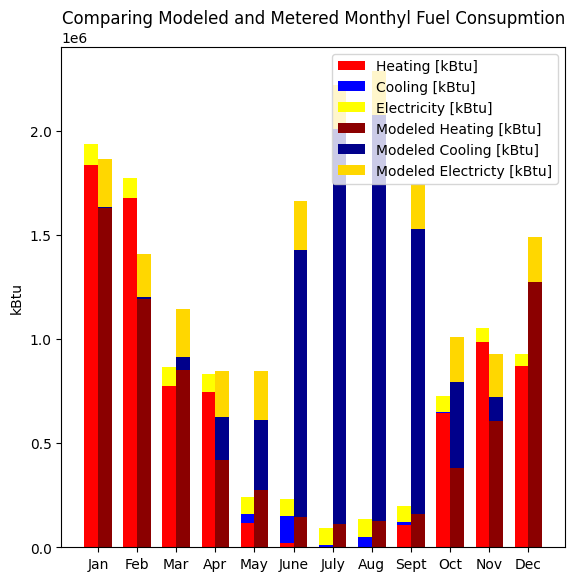

In [52]:
gsf = 1 #111135
gsfm = 1 #70580

labels = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']
Heating = heatMet #np.array(df2012['STEAM [kBTU]']/gsf)
Cooling = chwMet #np.array(df2012['CHW [kBTU]']/gsf)
Elec = elecMet #np.array(df2012['ELEC [kBTU]']/gsf)

mHeating = np.array((dfmi['DistrictHeating:Facility [kBtu](Monthly) ']/gsfm))
mCooling = np.array(dfmi['DistrictCooling:Facility [ton-hr](Monthly)']*12008.0336053/(1000*gsfm))
mElec = np.array(dfmi['Electricity:Facility [kWh](Monthly)']*3.412/gsfm)

x = np.arange(len(labels))
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(6.5,6.5))

ax.bar(x - width/2, Heating, width, label='Heating [kBtu]', color='r')
ax.bar(x - width/2, Cooling, width, bottom=Heating, label='Cooling [kBtu]', color='b')
ax.bar(x - width/2, Elec, width, bottom=(Heating+Cooling), label='Electricity [kBtu]', color='yellow')

ax.bar(x + width/2, mHeating, width, label='Modeled Heating [kBtu]', color='darkred')
ax.bar(x + width/2, mCooling, width, bottom=mHeating, label='Modeled Cooling [kBtu]', color='darkblue')
ax.bar(x + width/2, mElec, width, bottom=(mHeating+mCooling), label='Modeled Electricty [kBtu]', color='gold')


ax.set_ylabel('kBtu')
ax.set_xticks(x, labels)
ax.set_title('Comparing Modeled and Metered Monthyl Fuel Consupmtion')
ax.legend()

plt.show()

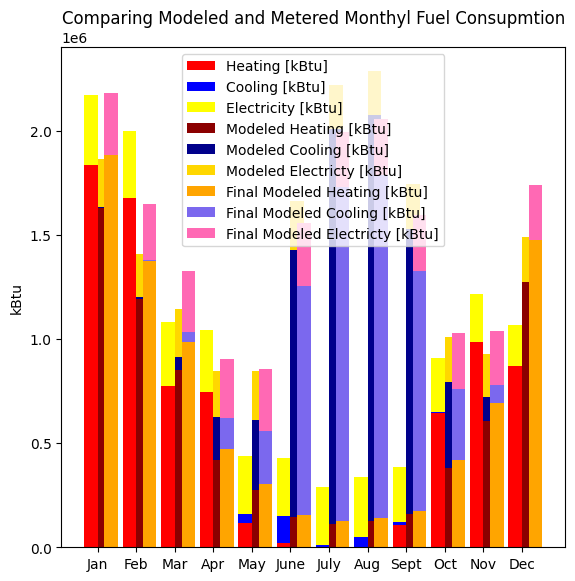

In [53]:
gsf = 1 #111135
gsfm = 1 #70580

labels = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']
Heating = np.array(df2012['STEAM [kBTU]']/gsf)
Cooling = np.array(df2012['CHW [kBTU]']/gsf)
Elec = np.array(df2012['ELEC [kBTU]']/gsf)

mHeating = np.array((dfmi['DistrictHeating:Facility [kBtu](Monthly) ']/gsfm))
mCooling = np.array(dfmi['DistrictCooling:Facility [ton-hr](Monthly)']*12008.0336053/(1000*gsfm))
mElec = np.array(dfmi['Electricity:Facility [kWh](Monthly)']*3.412/gsfm)

mfHeating = np.array((dfm['DistrictHeating:Facility [kBtu](Monthly) ']/gsfm))
mfCooling = np.array(dfm['DistrictCooling:Facility [ton-hr](Monthly)']*12008.0336053/(1000*gsfm))
mfElec = np.array(dfm['Electricity:Facility [kWh](Monthly)']*3.412/gsfm)

x = np.arange(len(labels))
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(6.5,6.5))

ax.bar(x - width/2, Heating, width, label='Heating [kBtu]', color='r')
ax.bar(x - width/2, Cooling, width, bottom=Heating, label='Cooling [kBtu]', color='b')
ax.bar(x - width/2, Elec, width, bottom=Heating+Cooling, label='Electricity [kBtu]', color='yellow')

ax.bar(x + width/2, mHeating, width, label='Modeled Heating [kBtu]', color='darkred')
ax.bar(x + width/2, mCooling, width, bottom=mHeating, label='Modeled Cooling [kBtu]', color='darkblue')
ax.bar(x + width/2, mElec, width, bottom=mHeating+mCooling, label='Modeled Electricty [kBtu]', color='gold')

ax.bar(x + width, mfHeating, width, label='Final Modeled Heating [kBtu]', color='orange')
ax.bar(x + width, mfCooling, width, bottom=mfHeating, label='Final Modeled Cooling [kBtu]', color='mediumslateblue')
ax.bar(x + width, mfElec, width, bottom=(mfHeating+mfCooling), label='Final Modeled Electricty [kBtu]', color='hotpink')


ax.set_ylabel('kBtu')
ax.set_xticks(x, labels)
ax.set_title('Comparing Modeled and Metered Monthyl Fuel Consupmtion')
ax.legend()

plt.show()

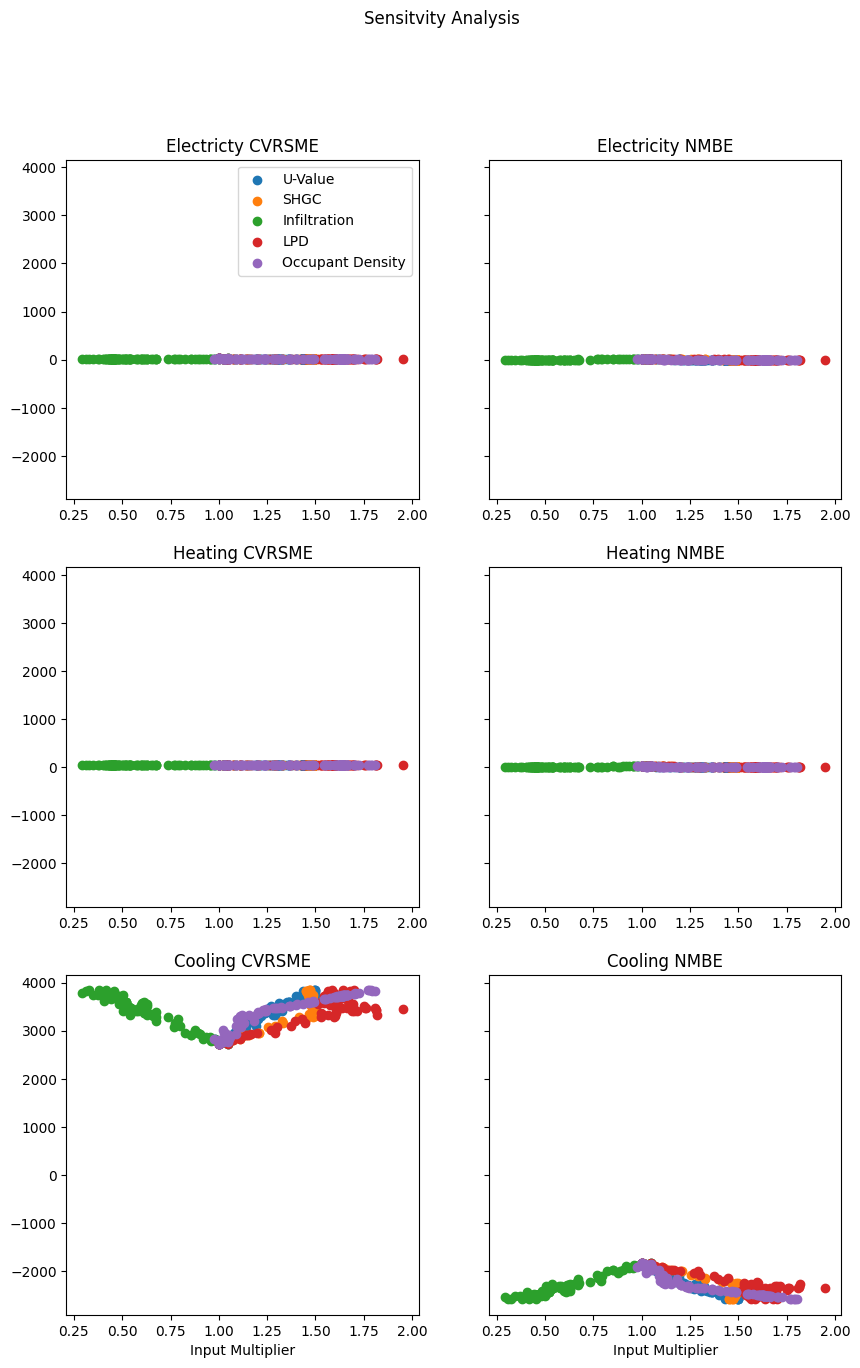

In [54]:
dfPartJ = pd.read_csv('resultsOut_noCHW.csv')

u = np.array(dfPartJ['u'])
shgc = np.array(dfPartJ['shgc'])
inf = np.array(dfPartJ['leakage'])
lpd = np.array(dfPartJ['lpd'])
people = np.array(dfPartJ['people'])

ec = np.array(dfPartJ['elecCVRSME'])
en = np.array(dfPartJ['elecNMBE'])
cc = np.array(dfPartJ['chwCVRSME'])
cn = np.array(dfPartJ['chwNMBE'])
hc = np.array(dfPartJ['heatCVRSME'])
hn = np.array(dfPartJ['heatNMBE'])

fig, axs = plt.subplots(3,2,figsize=(10,15),sharey=True)
axs[(0,0)].scatter(u,ec,label='U-Value')
axs[(0,0)].scatter(shgc,ec,label='SHGC')
axs[(0,0)].scatter(inf,ec,label='Infiltration')
axs[(0,0)].scatter(lpd,ec,label='LPD')
axs[(0,0)].scatter(people,ec,label='Occupant Density')
axs[(0,0)].set_title('Electricty CVRSME')


axs[(1,0)].scatter(u,hc,label='U-Value')
axs[(1,0)].scatter(shgc,hc,label='SHGC')
axs[(1,0)].scatter(inf,hc,label='Infiltration')
axs[(1,0)].scatter(lpd,hc,label='LPD')
axs[(1,0)].scatter(people,hc,label='Occupant Density')
axs[(1,0)].set_title('Heating CVRSME')

axs[(2,0)].scatter(u,cc,label='U-Value')
axs[(2,0)].scatter(shgc,cc,label='SHGC')
axs[(2,0)].scatter(inf,cc,label='Infiltration')
axs[(2,0)].scatter(lpd,cc,label='LPD')
axs[(2,0)].scatter(people,cc,label='Occupant Density')
axs[(2,0)].set_title('Cooling CVRSME')
axs[(2,0)].set_xlabel('Input Multiplier')

axs[(0,1)].scatter(u,en,label='U-Value')
axs[(0,1)].scatter(shgc,en,label='SHGC')
axs[(0,1)].scatter(inf,en,label='Infiltration')
axs[(0,1)].scatter(lpd,en,label='LPD')
axs[(0,1)].scatter(people,en,label='Occupant Density')
axs[(0,1)].set_title('Electricity NMBE')

axs[(1,1)].scatter(u,hn,label='U-Value')
axs[(1,1)].scatter(shgc,hn,label='SHGC')
axs[(1,1)].scatter(inf,hn,label='Infiltration')
axs[(1,1)].scatter(lpd,hn,label='LPD')
axs[(1,1)].scatter(people,hn,label='Occupant Density')
axs[(1,1)].set_title('Heating NMBE')

axs[(2,1)].scatter(u,cn,label='U-Value')
axs[(2,1)].scatter(shgc,cn,label='SHGC')
axs[(2,1)].scatter(inf,cn,label='Infiltration')
axs[(2,1)].scatter(lpd,cn,label='LPD')
axs[(2,1)].scatter(people,cn,label='Occupant Density')
axs[(2,1)].set_title('Cooling NMBE')
axs[(2,1)].set_xlabel('Input Multiplier')

ax.set_ylabel('kBtu/sf')
ax.set_xticks(x, labels)
fig.suptitle('Sensitvity Analysis')
axs[(0,0)].legend(loc='upper right')

plt.show()

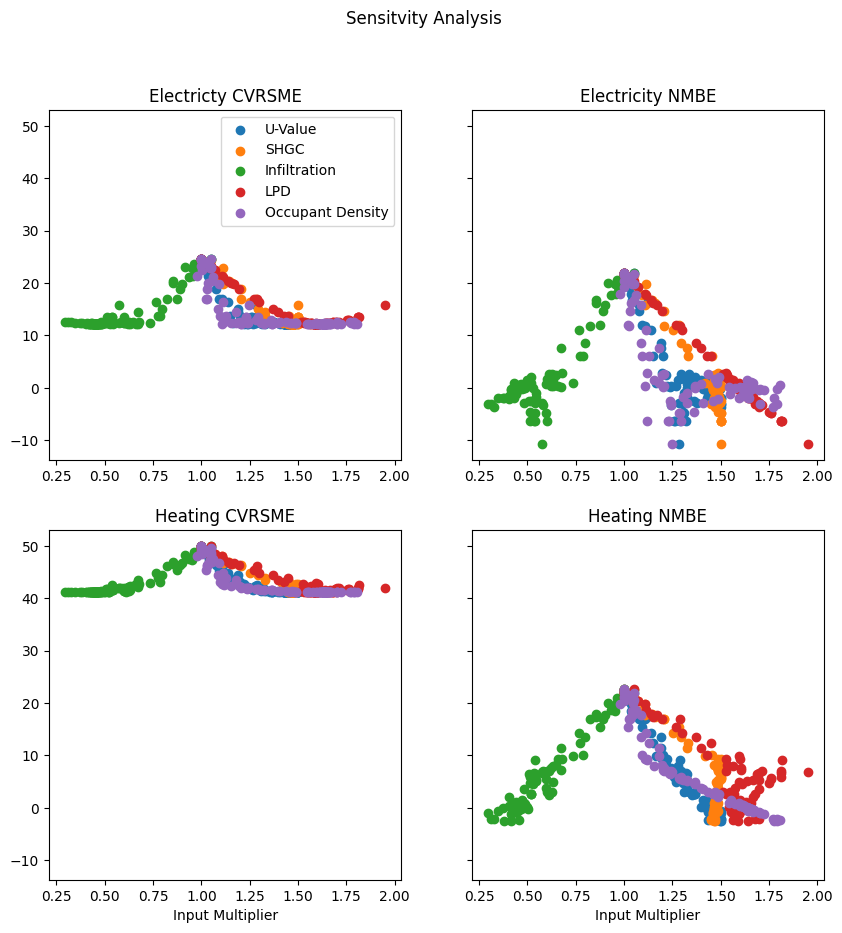

In [55]:
dfPartJ = pd.read_csv('resultsOut_noCHW.csv')

u = np.array(dfPartJ['u'])
shgc = np.array(dfPartJ['shgc'])
inf = np.array(dfPartJ['leakage'])
lpd = np.array(dfPartJ['lpd'])
people = np.array(dfPartJ['people'])

ec = np.array(dfPartJ['elecCVRSME'])
en = np.array(dfPartJ['elecNMBE'])
cc = np.array(dfPartJ['chwCVRSME'])
cn = np.array(dfPartJ['chwNMBE'])
hc = np.array(dfPartJ['heatCVRSME'])
hn = np.array(dfPartJ['heatNMBE'])

fig, axs = plt.subplots(2,2,figsize=(10,10),sharey=True)
axs[(0,0)].scatter(u,ec,label='U-Value')
axs[(0,0)].scatter(shgc,ec,label='SHGC')
axs[(0,0)].scatter(inf,ec,label='Infiltration')
axs[(0,0)].scatter(lpd,ec,label='LPD')
axs[(0,0)].scatter(people,ec,label='Occupant Density')
axs[(0,0)].set_title('Electricty CVRSME')


axs[(1,0)].scatter(u,hc,label='U-Value')
axs[(1,0)].scatter(shgc,hc,label='SHGC')
axs[(1,0)].scatter(inf,hc,label='Infiltration')
axs[(1,0)].scatter(lpd,hc,label='LPD')
axs[(1,0)].scatter(people,hc,label='Occupant Density')
axs[(1,0)].set_title('Heating CVRSME')
axs[(1,0)].set_xlabel('Input Multiplier')

# axs[(2,0)].scatter(u,cc,label='U-Value')
# axs[(2,0)].scatter(shgc,cc,label='SHGC')
# axs[(2,0)].scatter(inf,cc,label='Infiltration')
# axs[(2,0)].scatter(lpd,cc,label='LPD')
# axs[(2,0)].scatter(people,cc,label='Occupant Density')
# axs[(2,0)].set_title('Cooling CVRSME')

axs[(0,1)].scatter(u,en,label='U-Value')
axs[(0,1)].scatter(shgc,en,label='SHGC')
axs[(0,1)].scatter(inf,en,label='Infiltration')
axs[(0,1)].scatter(lpd,en,label='LPD')
axs[(0,1)].scatter(people,en,label='Occupant Density')
axs[(0,1)].set_title('Electricity NMBE')

axs[(1,1)].scatter(u,hn,label='U-Value')
axs[(1,1)].scatter(shgc,hn,label='SHGC')
axs[(1,1)].scatter(inf,hn,label='Infiltration')
axs[(1,1)].scatter(lpd,hn,label='LPD')
axs[(1,1)].scatter(people,hn,label='Occupant Density')
axs[(1,1)].set_title('Heating NMBE')
axs[(1,1)].set_xlabel('Input Multiplier')

# axs[(2,1)].scatter(u,cn,label='U-Value')
# axs[(2,1)].scatter(shgc,cn,label='SHGC')
# axs[(2,1)].scatter(inf,cn,label='Infiltration')
# axs[(2,1)].scatter(lpd,cn,label='LPD')
# axs[(2,1)].scatter(people,cn,label='Occupant Density')
# axs[(2,1)].set_title('Cooling NMBE')

ax.set_ylabel('kBtu/sf')
ax.set_xticks(x, labels)
fig.suptitle('Sensitvity Analysis')
axs[(0,0)].legend(loc='upper right')

plt.show()